In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [3]:
apt_tr = train[train['임대건물구분']=='아파트']
store_tr = train[train['임대건물구분']=='상가']

apt_test = test[test['임대건물구분']=='아파트']
store_test = test[test['임대건물구분']=='상가']

In [4]:
print(train.shape)
print(test.shape)

(2896, 34)
(1008, 33)


In [5]:
train['공가수_비율'] =  train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['공가수_비율'] =  test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

In [6]:
train['0~19 인구수'] = train['0~19세_비율']*train['총세대수']
train['20~39 인구수'] = train['20~39세_비율']*train['총세대수']
train['40~69 인구수'] = train['40~69세_비율']*train['총세대수']
train['70세이상 인구수'] = train['70세이상_비율']*train['총세대수']

In [7]:
test['0~19 인구수'] = test['0~19세_비율']*test['총세대수']
test['20~39 인구수'] = test['20~39세_비율']*test['총세대수']
test['40~69 인구수'] = test['40~69세_비율']*test['총세대수']
test['70세이상 인구수'] = test['70세이상_비율']*test['총세대수']

In [8]:
area = ['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시']
for ind in range(train.shape[0]):
    if train.loc[ind,'지역'] in area :
        train.loc[ind,'환승역 수'] = 0
train = train.join(pd.get_dummies(train['환승역 수'],prefix='sub')).iloc[:,:-1]
train = train.drop('환승역 수',axis=1)

In [9]:
for ind in range(test.shape[0]):
    if test.loc[ind,'지역'] in area :
        test.loc[ind,'환승역 수'] = 0
test = test.join(pd.get_dummies(test['환승역 수'],prefix='sub')).iloc[:,:-1]
test = test.drop('환승역 수',axis=1)

In [10]:
def func2(x):
    if x<0.005: 
        return 0
    elif 0.005<x<0.02:
        return 1
    elif 0.02<x<1:
        return 2
    elif x>1:
        return 3

In [11]:
train['sub_cat'] = train['subway_dist'].apply(lambda x : func2(x))
test['sub_cat'] = test['subway_dist'].apply(lambda x : func2(x))

In [12]:
train = train.join(pd.get_dummies(train['sub_cat'],prefix='sub_dist')).iloc[:,:-1]
train = train.drop(['subway_dist','sub_cat'],axis=1)

In [13]:
test = test.join(pd.get_dummies(test['sub_cat'],prefix='sub_dist')).iloc[:,:-1]
test = test.drop(['subway_dist','sub_cat'],axis=1)

###  공급유형 

In [14]:
def func3(x,dic):
    for i in dic.keys():
        if len(dic[i]) == len(x):
            if all(dic[i] == x):
                return i

In [15]:
# # 방안 1 

# train.loc[train['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'
# test.loc[test['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'

# no_shop = train[train['공급유형']!='임대상가']
# uniq = np.reshape(no_shop['공급유형'].unique(),(8,1))

# dic = dict(enumerate(uniq))
# dic[8] = ['장기전세', '공공임대(10년)', '공공임대(분납)']
# dic[9] = ['장기전세', '국민임대', '영구/행복']
# dic[10] = ['국민임대', '영구/행복']
# dic[11] = ['공공임대(10년)', '공공임대(분납)']
# dic[12] = ['공공분양', '공공임대(10년)', '공공임대(분납)']
# dic[13] = ['공공임대(10년)', '국민임대']
# dic[14] = ['공공임대(50년)', '영구/행복']

# # train
# no_shop = train[train['공급유형']!='임대상가']
# sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
# sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
# train = pd.merge(train,sample[['단지코드','cluster']],on='단지코드',how='left')
# train = train.join(pd.get_dummies(train['cluster'],prefix='type')).iloc[:,:-1]
# train = train.drop(['공급유형','cluster'],axis=1)

# # test
# no_shop = test[test['공급유형']!='임대상가']
# sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
# sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
# test = pd.merge(test,sample[['단지코드','cluster']],on='단지코드',how='left')
# test = test.join(pd.get_dummies(test['cluster'],prefix='type')).iloc[:,:-1]
# test = test.drop(['공급유형','cluster'],axis=1)

In [16]:
# 방안 2 

train.loc[train['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'
test.loc[test['공급유형'].isin(['영구임대', '행복주택']),'공급유형'] = '영구/행복'

train.loc[train['공급유형'].isin(['공공임대(10년)', '공공임대(5년)']),'공급유형'] = '공공임대(단기)'
test.loc[test['공급유형'].isin(['공공임대(10년)', '공공임대(5년)']),'공급유형'] = '공공임대(단기)'

no_shop = train[train['공급유형']!='임대상가']
uniq = np.reshape(no_shop['공급유형'].unique(),(7,1))

dic = dict(enumerate(uniq))
dic[8] = ['공공임대(단기)', '국민임대']
dic[9] = ['장기전세', '국민임대', '영구/행복']
dic[10] = ['국민임대', '영구/행복']
dic[11] = ['공공임대(단기)', '공공임대(분납)']
dic[12] = ['공공분양', '공공임대(단기)', '공공임대(분납)']
dic[13] = ['공공임대(50년)', '영구/행복']
dic[14] = ['장기전세', '공공임대(단기)', '공공임대(분납)']

# train
no_shop = train[train['공급유형']!='임대상가']
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
sample['cluster'] = sample['cluster'].apply(lambda x: int(x))
train = pd.merge(train,sample[['단지코드','cluster']],on='단지코드',how='left')
train = train.join(pd.get_dummies(train['cluster'],prefix='type')).iloc[:,:-1]
train = train.drop(['공급유형','cluster'],axis=1)

# test
no_shop = test[test['공급유형']!='임대상가']
sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].unique()).reset_index()
sample['cluster'] = sample['공급유형'].apply(lambda x : func3(x,dic))
test = pd.merge(test,sample[['단지코드','cluster']],on='단지코드',how='left')
test = test.join(pd.get_dummies(test['cluster'],prefix='type')).iloc[:,:-1]
test = test.drop(['공급유형','cluster'],axis=1)
test['type_8'] = 0
test['type_9'] = 0
test['type_11'] = 0
test['type_12'] = 0
test['type_13'] = 0

# sample = pd.DataFrame(no_shop.groupby('단지코드')['공급유형'].nunique()).reset_index()
# ind = sample[sample['공급유형']>1]['단지코드'].values
# no_shop.loc[no_shop['단지코드'].isin(ind),:].groupby('단지코드')['공급유형'].unique()

In [17]:
dic

{0: array(['국민임대'], dtype=object),
 1: array(['공공임대(50년)'], dtype=object),
 2: array(['영구/행복'], dtype=object),
 3: array(['공공임대(단기)'], dtype=object),
 4: array(['공공임대(분납)'], dtype=object),
 5: array(['장기전세'], dtype=object),
 6: array(['공공분양'], dtype=object),
 8: ['공공임대(단기)', '국민임대'],
 9: ['장기전세', '국민임대', '영구/행복'],
 10: ['국민임대', '영구/행복'],
 11: ['공공임대(단기)', '공공임대(분납)'],
 12: ['공공분양', '공공임대(단기)', '공공임대(분납)'],
 13: ['공공임대(50년)', '영구/행복'],
 14: ['장기전세', '공공임대(단기)', '공공임대(분납)']}

In [17]:
drop = ['남/여비율','남/여_0~19세','남/여_20~39세','남/여_40~69세','남/여_70세이상','0~19세_비율','20~39세_비율','40~69세_비율','70세이상_비율']
drop1 = ['총세대수','임대건물구분','지역','공가수','자격유형','단지내주차면수','단지명','도로명주소','subway_name']

In [18]:
train = train.drop(drop,axis=1)
test = test.drop(drop,axis=1)

In [19]:
train = train.drop(drop1,axis=1)
test = test.drop(drop1,axis=1)

In [20]:
non_unique = ['전용면적','전용면적별세대수','임대보증금','임대료']
train_one = train.drop(non_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(non_unique,axis=1).drop_duplicates().reset_index(drop=True)

In [21]:
def merge(col,standard,oldDF,newDF,kind):
    sample = oldDF.groupby('단지코드').describe()[col].reset_index()
    for i in sample.index:
        for j in standard:
            code = sample.loc[i,'단지코드']
            val = sample.loc[i,j]
            ind = newDF[newDF['단지코드']==code].index
            newDF.loc[ind,kind+col+j] = val
    return newDF

In [22]:
train_one = merge('임대료',['min','25%','50%','75%','max'],apt_tr,train_one,'apt')
train_one = merge('임대보증금',['min','25%','50%','75%','max'],apt_tr,train_one,'apt')

train_one = merge('임대료',['min','25%','50%','75%','max'],store_tr,train_one,'store')
train_one = merge('임대보증금',['min','25%','50%','75%','max'],store_tr,train_one,'store')

train_one = merge('전용면적',['min','25%','50%','75%','max'],apt_tr,train_one,'apt')
train_one = merge('전용면적',['mean','std'],store_tr,train_one,'store')

train_one = train_one.replace(np.nan, 0)

In [23]:
test_one = merge('임대료',['min','25%','50%','75%','max'],apt_test,test_one,'apt')
test_one = merge('임대보증금',['min','25%','50%','75%','max'],apt_test,test_one,'apt')

test_one = merge('임대료',['min','25%','50%','75%','max'],store_test,test_one,'store')
test_one = merge('임대보증금',['min','25%','50%','75%','max'],store_test,test_one,'store')

test_one = merge('전용면적',['min','25%','50%','75%','max'],apt_test,test_one,'apt')
test_one = merge('전용면적',['mean','std'],store_test,test_one,'store')

test_one = test_one.replace(np.nan, 0)

In [24]:
print(train_one.shape)
print(test_one.shape)

(414, 57)
(147, 56)


In [25]:
train_one.corr()['등록차량수']

지하철역            -0.0069
버스정류장            0.1125
등록차량수            1.0000
연면적              0.2248
위도              -0.1013
경도               0.1240
총인구수             0.2809
세대당_인구           0.4047
공가수_비율          -0.2952
세대당_가능주차면수       0.5242
0~19 인구수         0.7024
20~39 인구수        0.6466
40~69 인구수        0.5316
70세이상 인구수        0.1033
sub_0           -0.2267
sub_1            0.2056
sub_dist_0      -0.0973
sub_dist_1       0.2296
sub_dist_2      -0.1225
type_0           0.0228
type_1          -0.1007
type_2          -0.3772
type_3           0.3672
type_8           0.0810
type_9           0.0094
type_10          0.0780
type_11         -0.0077
type_12          0.2195
type_13         -0.0460
apt임대료min        0.3813
apt임대료25%        0.4190
apt임대료50%        0.4762
apt임대료75%        0.4900
apt임대료max        0.5228
apt임대보증금min      0.3852
apt임대보증금25%      0.3968
apt임대보증금50%      0.3971
apt임대보증금75%      0.3967
apt임대보증금max      0.3511
store임대료min     -0.1197
store임대료25%     -0.1211
store임대료50%     

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

from catboost import CatBoostRegressor

In [27]:
X = train_one.drop(['등록차량수','단지코드'],axis=1)
y = train_one['등록차량수']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2021,shuffle=True)

cb = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(X_train, y_train)
pred = cb.predict(X_test)

mae(pred,y_test) 

119.57314535543328

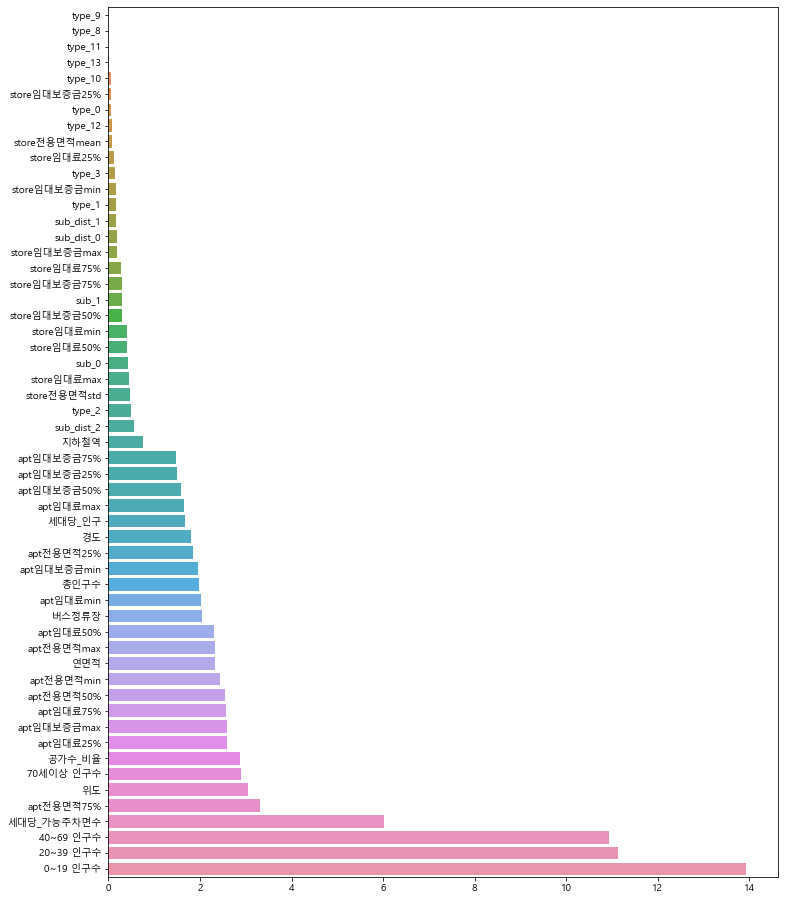

In [28]:
plt.figure(figsize=(12,16))
sns.barplot(y = X_train.columns[np.argsort(cb.feature_importances_)], x = list(cb.feature_importances_[np.argsort(cb.feature_importances_)]))

In [38]:
test_one = test_one.rename(columns={'type8':'type_8','type9':'type_9','type11':'type_11','type12':'type_12','type13':'type_13'})

In [41]:
real_x = test_one.drop('단지코드',axis=1)
real_y = cb.predict(real_x)

In [43]:
def myfunc():
    cb = pd.read_csv("0713_cb.csv")
    cb = cb.loc[-cb['code'].isin(['C2675', 'C2335', 'C1327']),:].reset_index(drop=True)
    return cb

In [44]:
res = myfunc()
mae(real_y,res['num'])

56.79888147484477

In [46]:
res['new_y'] = real_y
res.head()

,code,num,new_y
0,C1072,682.5972,761.4265
1,C1128,"1,171.7943","1,093.0518"
2,C1456,530.1717,552.8985
3,C1840,528.1426,500.7122
4,C1332,"1,119.5004","1,166.7916"


In [53]:
result = pd.read_csv("data/result.csv")
result['y2'] = real_y

result.to_csv("data/result.csv",index=False)

In [50]:
train_one.to_csv("data/train2.csv",index=False)
test_one.to_csv("data/test2.csv",index=False)